# Semantic Segmentation Using U-Net
### Artificial Intelligence Course | Instructed by DR. MohammadHossein Rohban
<font color='cyan'> Responsible TAs: Amirhossein Razlighi, Reza Vahidimajd </font>

<font color='yellow'> Please ask your questions via [Quera](www.quera.com) </font>

Author:
| Name | Student Number |
| :---- | :---: |
| <font color='cyan'> Mohammad Shafizadeh </font> | 401 110 386 |

In this excercise, you will design and train a CNN-based network called U-Net. This type of networks are used for semantic segmentation. This task is, as it's called, segmenting the image, semantically to different parts. You can consider this as a classification, done on each pixel of the image! Below, you can see an example of the task:


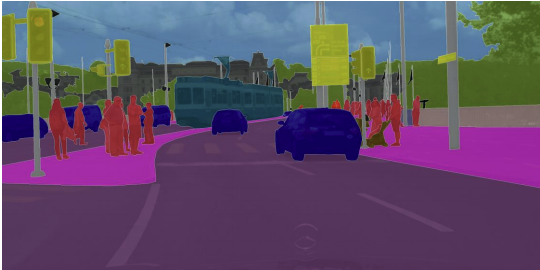 <br>
Example of a segmented image <br>


We will use a dataset which is used for "Self-Driving Car" Purposes. As you may know, understanding each pixel (in the view point of car) is an important task for self-driving cars. Let's proceed with this task to the end of this excercise!

## Downloading Dataset

In [1]:
%pip install --upgrade --no-cache-dir gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
!gdown --id 11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3
From (redirected): https://drive.google.com/uc?id=11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3&confirm=t&uuid=c6901742-69cf-4487-8164-a578be81f2de
To: /kaggle/working/Files.zip
100%|████████████████████████████████████████| 545M/545M [00:11<00:00, 48.3MB/s]


In [3]:
!unzip Files.zip

Archive:  Files.zip
  inflating: Files/data/CameraRGB/002128.png  
  inflating: Files/data/CameraRGB/008579.png  
  inflating: Files/data/CameraRGB/015232.png  
  inflating: Files/data/CameraRGB/006878.png  
  inflating: Files/data/CameraRGB/008104.png  
  inflating: Files/data/CameraRGB/002281.png  
  inflating: Files/data/CameraRGB/004063.png  
  inflating: Files/data/CameraRGB/049745.png  
  inflating: Files/data/CameraRGB/013414.png  
  inflating: Files/data/CameraRGB/011470.png  
  inflating: Files/data/CameraRGB/022243.png  
  inflating: Files/data/CameraRGB/049187.png  
  inflating: Files/data/CameraRGB/011056.png  
  inflating: Files/data/CameraRGB/049727.png  
  inflating: Files/data/CameraRGB/006896.png  
  inflating: Files/data/CameraRGB/012028.png  
  inflating: Files/data/CameraRGB/009569.png  
  inflating: Files/data/CameraRGB/007787.png  
  inflating: Files/data/CameraRGB/010561.png  
  inflating: Files/data/CameraRGB/064397.png  
  inflating: Files/data/CameraRGB/015016

In [4]:
# %pip install --upgrade torch torchvision torchsummary
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


<a name='1'></a>
## 1 - Packages

Run the cell below to import all the libraries you'll need:

In [166]:
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

### Set torch device to appropriate type for GPU training

In [167]:
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else (
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available() else "cpu"
    )
)
device

device(type='cuda')

<a name='2'></a>
## 2 - Load the Data

In [168]:
path = "" # Path to the root folder
image_path = os.path.join(path, "Files/data/CameraRGB/")
mask_path = os.path.join(path, "Files/data/CameraMask/")
image_list = sorted(os.listdir(image_path))
mask_list = sorted(os.listdir(mask_path))
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

### Check out the some of the unmasked and masked images from the dataset:

After you are done exploring, revert back to `N=5`

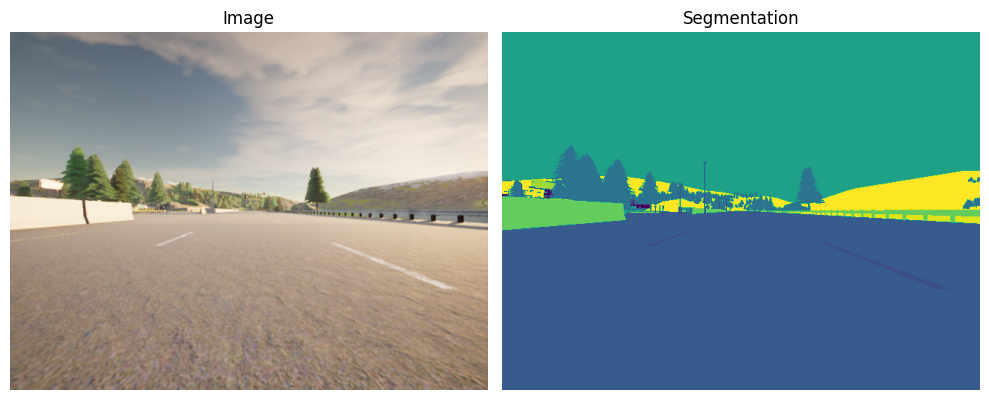

In [169]:
N = 5

img = image_list[N]
mask = mask_list[N]

# Plot the images and masks alongside each other
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(imageio.v2.imread(img))
ax[0].set_title("Image")
ax[0].axis("off")
ax[1].imshow(imageio.v2.imread(mask)[:, :, 0])
ax[1].set_title("Segmentation")
ax[1].axis("off")
plt.tight_layout()
plt.show()

<a name='2-2'></a>
### 2.2 - Preprocess Your Data



In [170]:
class Segmentation_Dataset(Dataset):
    def __init__(self, ImagesDirectory, MasksDirectory):
        self.images_dir = ImagesDirectory
        self.masks_dir = MasksDirectory
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        self.images_list = [os.path.join(self.images_dir, i) for i in self.images_list]
        self.masks_list = [os.path.join(self.masks_dir, i) for i in self.masks_list]
        # Your transform should contain: Resizing to 192x256 (and any more things you want to add!)
        self.mask_transforms = transforms.Compose(
            [
                transforms.Resize((192, 256), interpolation=Image.NEAREST),
                transforms.ToTensor(),
                lambda mask: mask[0],
                lambda mask: (255 * mask).type(torch.LongTensor)
            ]
        )
        # Your transform should contain: Transforming to PIL image format, resizing to 192x256, 
        # converting to tensor and selecting only the first 3 channels (and any more things you want to add!)
        self.image_transforms = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize((192, 256)),
                transforms.ToTensor(),
                lambda x: x[:3, :, :]
            ]
        )

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, index):
        image = imageio.v2.imread(self.images_list[index])
        mask = imageio.v2.imread(self.masks_list[index])
        mask = self.mask_transforms(Image.fromarray(mask))
        image = self.image_transforms(image)
        return image, mask

<a name='2-3'></a>
### 2.3 - Hyper-parameters and Optimizer

In [171]:
EPOCHS = 15
BATCH_SIZE = 16
LR = 0.0005
B1 = 0.9
B2 = 0.999

<a name='3'></a>
## 3 - U-Net

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks.

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used.

You will see the transpose convolution referred to by several names, including "deconvolution" and "upconvolution", but these are all the same thing. You will also see the model's architecture in the following cells.

<a name='3-1'></a>
### 3.1 - Model Details

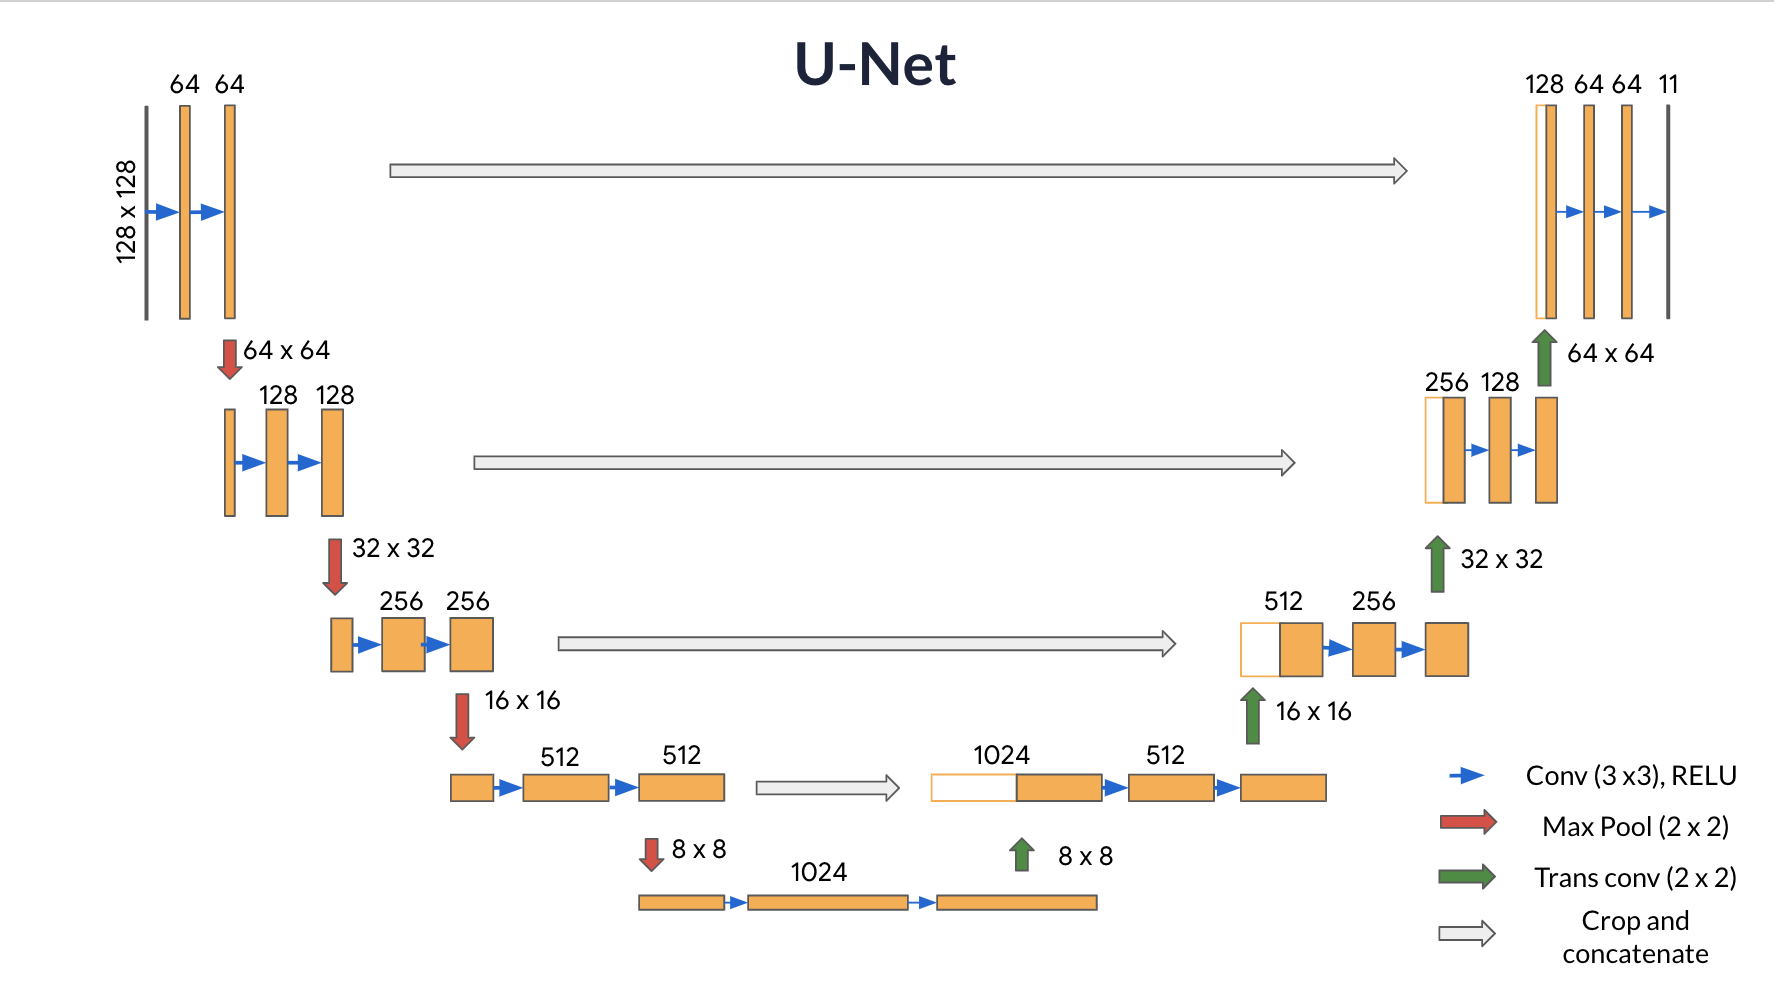<br>
U-Net Architecture<br>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 valid padding convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection.

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class.

The U-Net network has 23 convolutional layers in total.

**Important Note:**
The figures shown in the assignment for the U-Net architecture depict the layer dimensions and filter sizes as per the original paper on U-Net with smaller images. However, due to computational constraints for this assignment, you will code only half of those filters. The purpose of showing you the original dimensions is to give you the flavour of the original U-Net architecture. The important takeaway is that you multiply by 2 the number of filters used in the previous step. The notebook includes all of the necessary instructions and hints to help you code the U-Net architecture needed for this assignment.

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block)

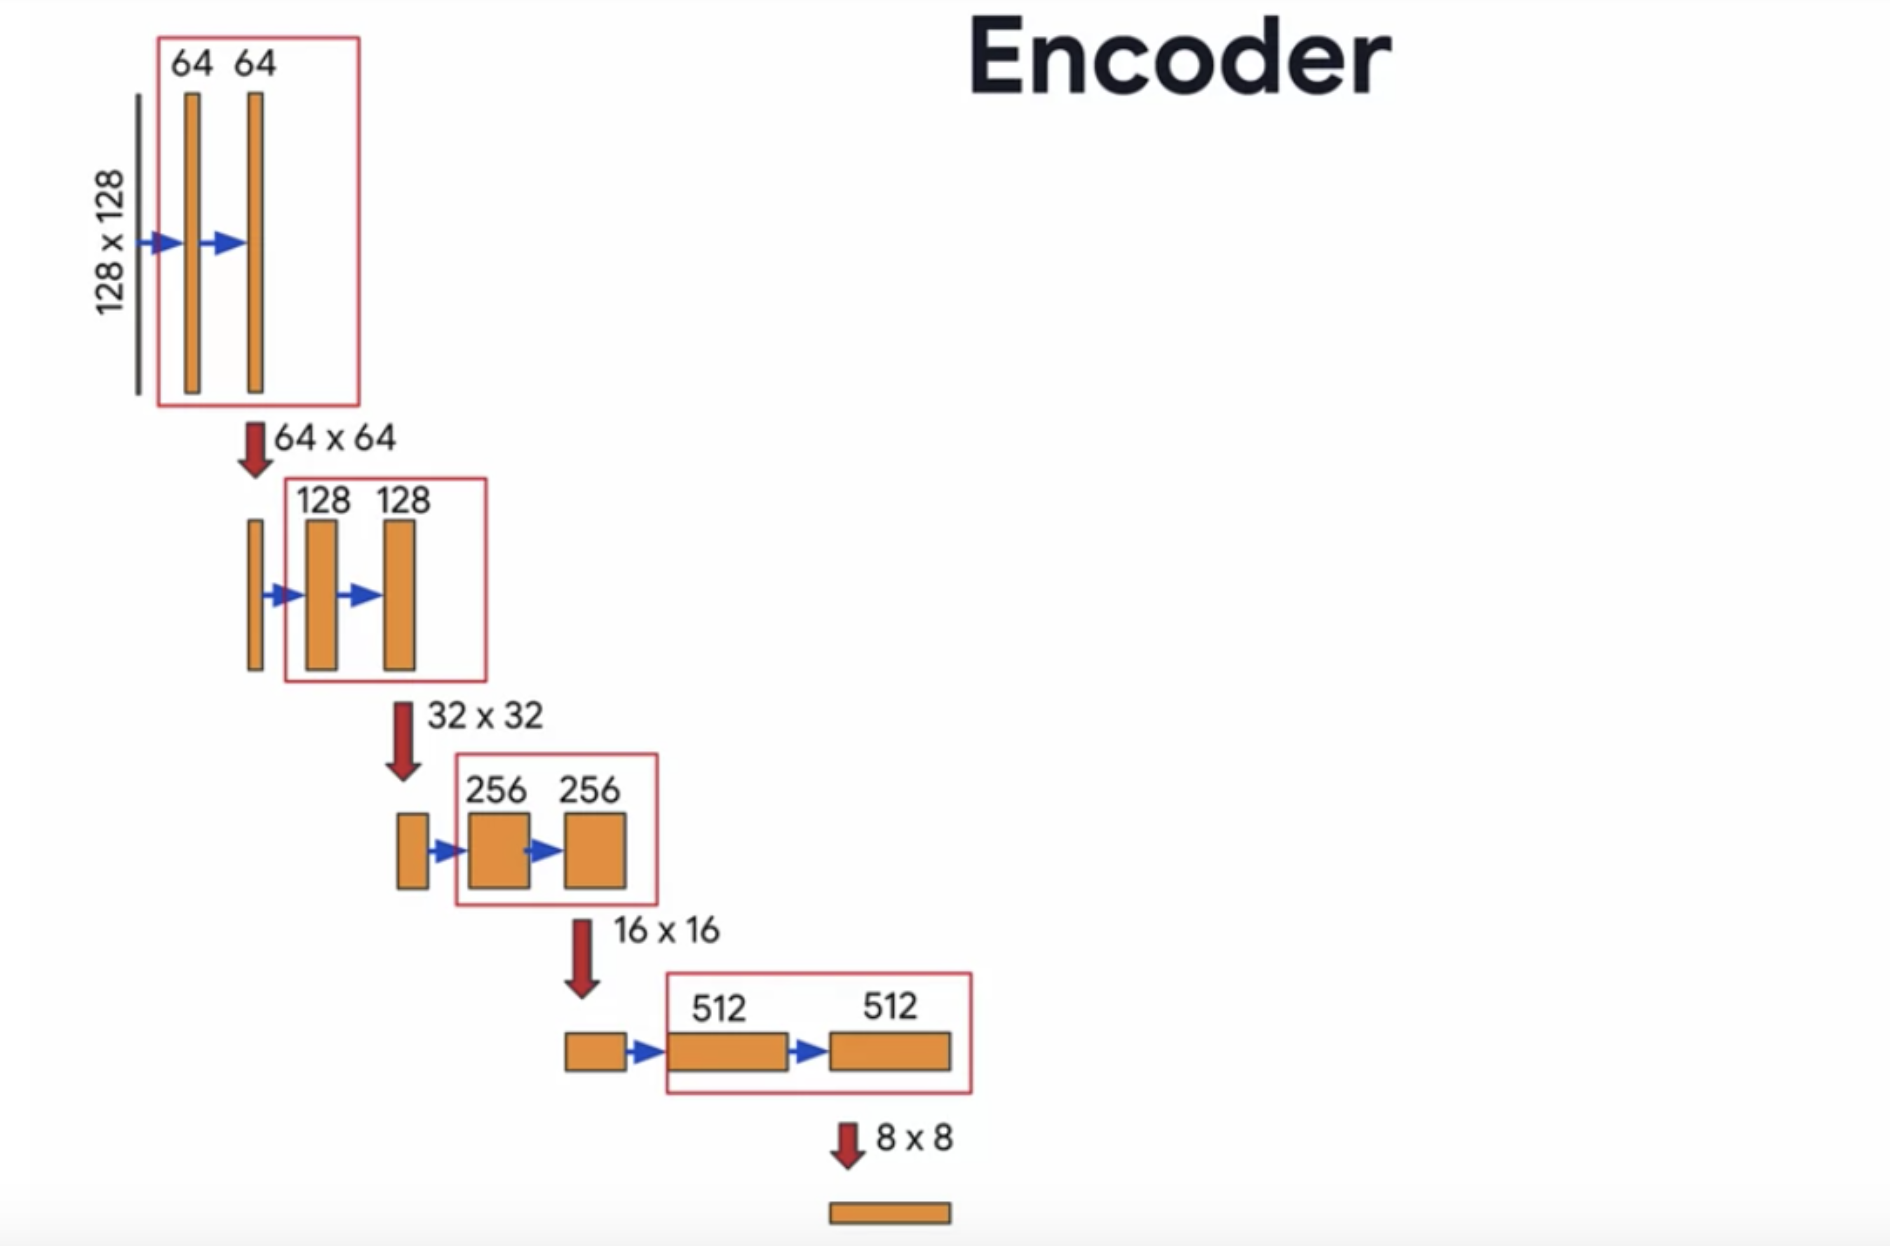<br>
The U-Net Encoder up close <br>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling.

The function will  return two tensors:
- `next_layer`: That will go into the next block.
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  

In [172]:
class conv_block(nn.Module):
    def __init__(self, in_ch, n_filters=32, dropout_prob=0, max_pooling=True):
        """
        Convolutional downsampling block

        Arguments:
            in_ch -- Number of channels of input tensor
            n_filters -- Number of filters for the convolutional layers
            dropout_prob -- Dropout probability
            max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
        """
        super().__init__()
        self.batch_norm1 = nn.BatchNorm2d(n_filters)
        self.batch_norm2 = nn.BatchNorm2d(n_filters)
        self.conv1 = nn.Conv2d(in_ch, n_filters, kernel_size=3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU()
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout2d(self.dropout_prob)
        self.max_pooling = max_pooling
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        """
        Convolutional downsampling forward

        Arguments:
            x -- Input data/batch
        Returns:
            next_layer, skip_connection --  Next layer and skip connection outputs
        """
        next_layer = self.relu(self.batch_norm1(self.conv1(x)))
        next_layer = self.relu(self.batch_norm2(self.conv2(next_layer)))
        if self.dropout_prob > 0:
            next_layer = self.dropout(next_layer)
        skip_connection = next_layer
        if self.max_pooling:
            next_layer = self.pool(next_layer)

        return next_layer, skip_connection

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

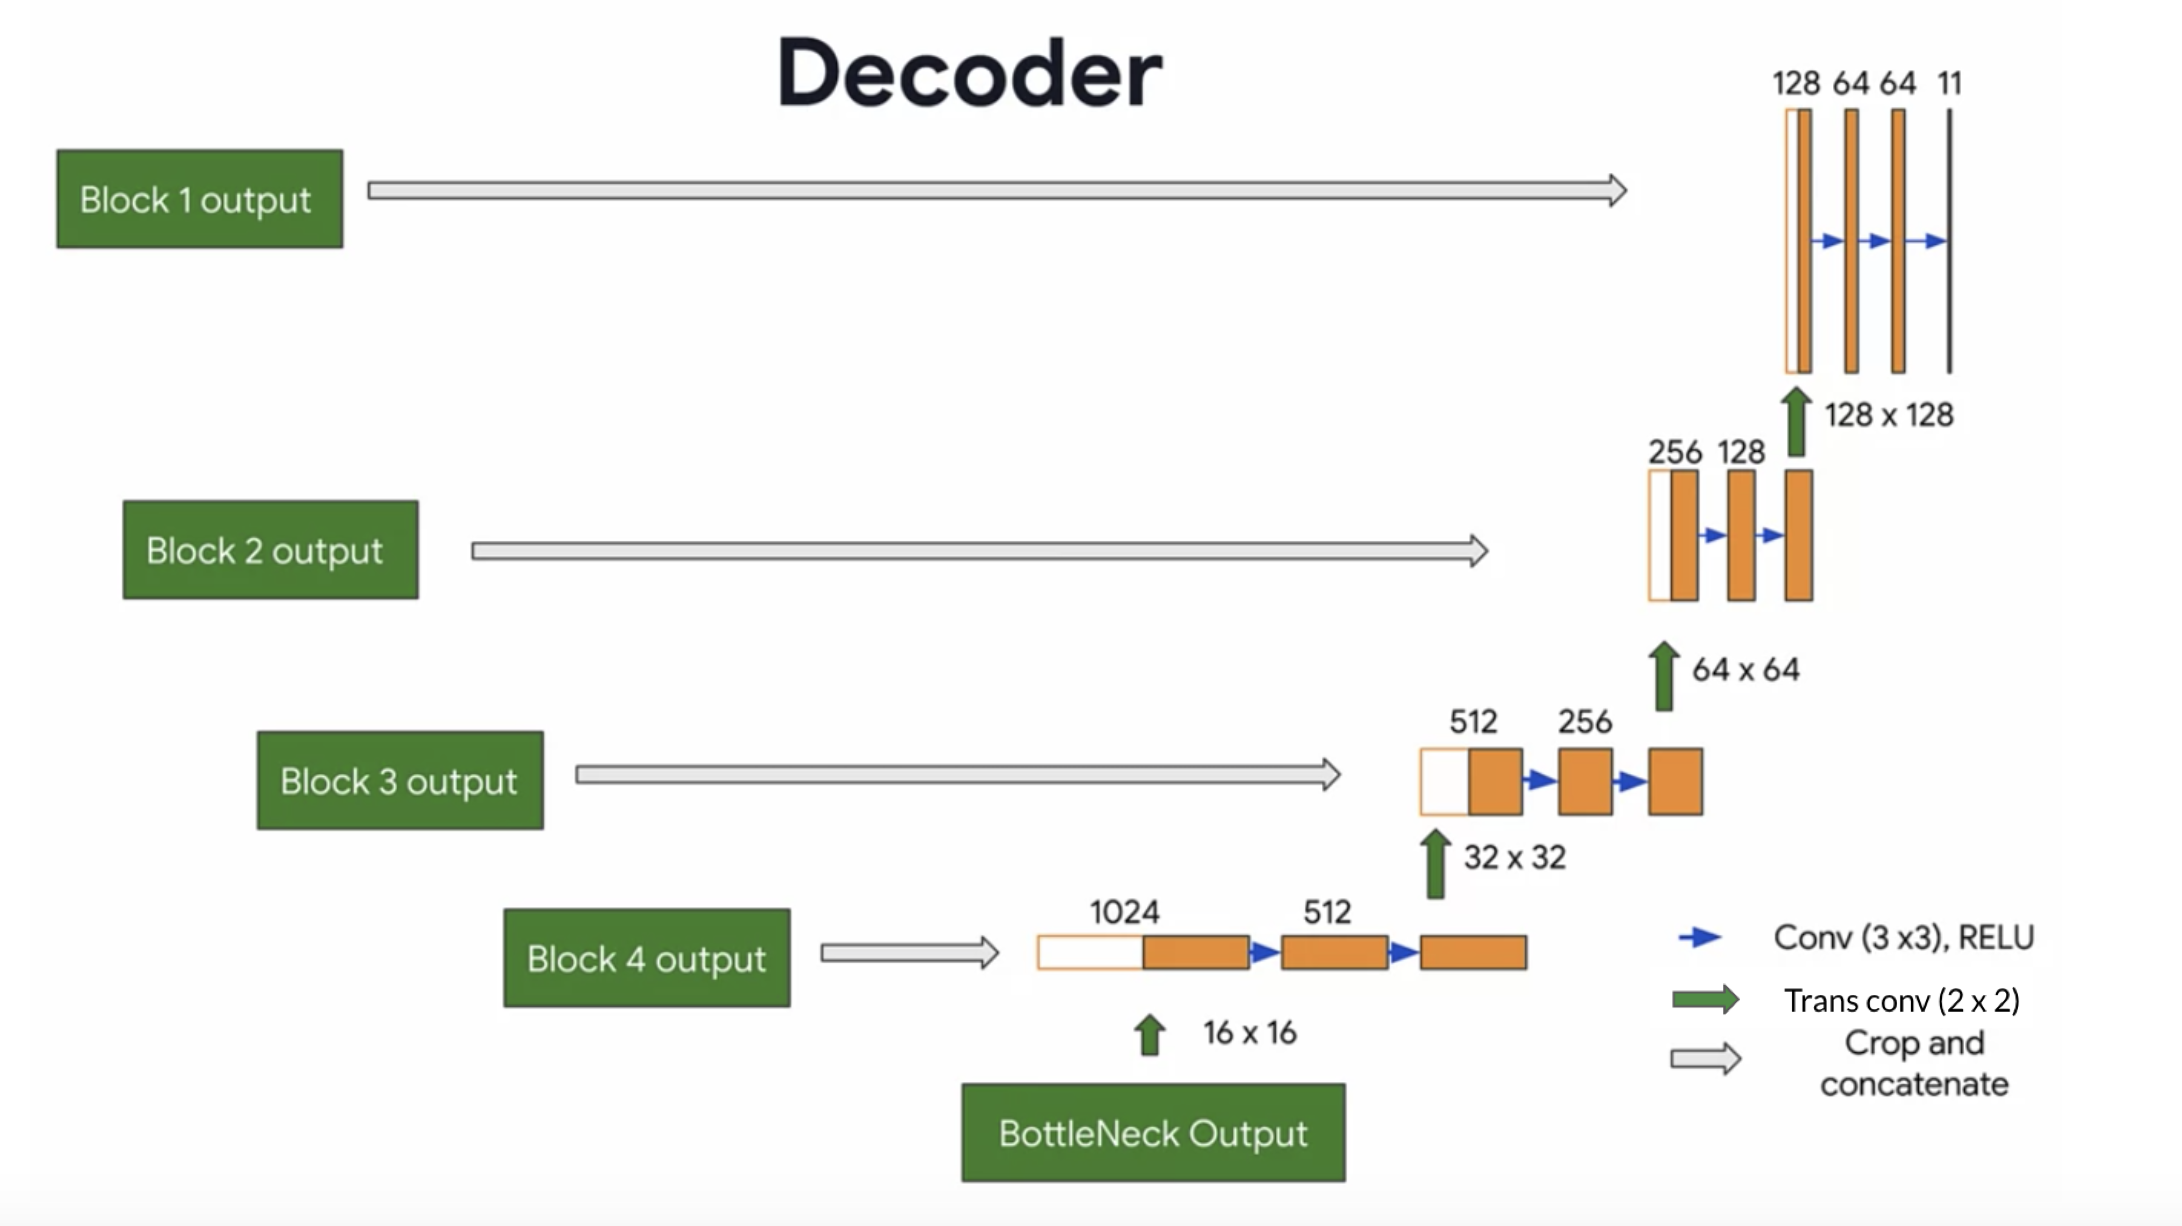<br>
The U-Net Decoder up close <br>

There are two new components in the decoder: `up` and `cat`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder.

Here you'll encounter the `ConvTranspose2d` layer, which performs the inverse of the `Conv2d` layer.



In [173]:
class upsampling_block(nn.Module):
    def __init__(self, in_ch, skip_ch, n_filters=32):
        """
        Convolutional upsampling block

        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            skip_ch -- Number of channels of input tensor from previous skip layer
            n_filters -- Number of filters for the convolutional layers
        """
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_ch, n_filters, kernel_size=2, stride=2)
        self.conv = conv_block(skip_ch + n_filters, n_filters, max_pooling=False)
        self.relu = nn.ReLU()

    def forward(self, expansive_input, contractive_input):
        """
        Convolutional upsampling forward

        Arguments:
            expansive_input -- Data from bottleneck or previous upsampling_block
            contractive_input -- Data from corresponding layer in the encoder
        Returns:
            conv -- Tensor output
        """
        upconv = self.relu(self.upconv(expansive_input))
        concat = torch.cat((upconv, contractive_input), dim=1)
        conv, _ = self.conv(concat)

        return conv

<a name='3-4'></a>
### 3.4 - Build the Model

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 23. **That's because there are 23 possible labels for each pixel in this self-driving car dataset.**

In [174]:
class UNet(nn.Module):
    def __init__(self, in_ch=3, n_filters=32, n_classes=23):
        """
        UNet

        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            n_filters -- Number of filters for the convolutional layers
            n_classes -- Number of diffrent segments
        """
        super().__init__()
        
        # Down-sampling
        self.conv_block1 = conv_block(in_ch, n_filters)
        self.conv_block2 = conv_block(n_filters, n_filters*2)
        self.conv_block3 = conv_block(n_filters*2, n_filters*4)
        self.conv_block4 = conv_block(n_filters*4, n_filters*8, dropout_prob=0.3)

        # Bottleneck
        self.bottleneck = conv_block(n_filters*8, n_filters*16, dropout_prob=0.3, max_pooling=False)

        # Up-sampling and final layer
        self.up_block1 = upsampling_block(n_filters*16, n_filters*8, n_filters*8)
        self.up_block2 = upsampling_block(n_filters*8, n_filters*4, n_filters*4)
        self.up_block3 = upsampling_block(n_filters*4, n_filters*2, n_filters*2)
        self.up_block4 = upsampling_block(n_filters*2, n_filters, n_filters)
        self.final_conv = nn.Conv2d(n_filters, n_classes, kernel_size=1)

    def forward(self, x):
        """
        UNet forward

        Arguments:
            x -- Input data/batch

        Returns:
            out -- Tensor output (Segmented image)
        """
        # Down-sampling
        x, skip1 = self.conv_block1(x)
        x, skip2 = self.conv_block2(x)
        x, skip3 = self.conv_block3(x)
        x, skip4 = self.conv_block4(x)

        # Bottleneck
        x, _ = self.bottleneck(x)
        
        # Up-sampling
        x = self.up_block1(x, skip4)
        x = self.up_block2(x, skip3)
        x = self.up_block3(x, skip2)
        x = self.up_block4(x, skip1)
        out = self.final_conv(x)

        return out

### Check out the model summary

In [175]:
unet = UNet().to(device)
summary(unet, (3, 192, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 192, 256]             864
       BatchNorm2d-2         [-1, 32, 192, 256]              64
              ReLU-3         [-1, 32, 192, 256]               0
            Conv2d-4         [-1, 32, 192, 256]           9,216
       BatchNorm2d-5         [-1, 32, 192, 256]              64
              ReLU-6         [-1, 32, 192, 256]               0
         MaxPool2d-7          [-1, 32, 96, 128]               0
        conv_block-8  [[-1, 32, 96, 128], [-1, 32, 192, 256]]               0
            Conv2d-9          [-1, 64, 96, 128]          18,432
      BatchNorm2d-10          [-1, 64, 96, 128]             128
             ReLU-11          [-1, 64, 96, 128]               0
           Conv2d-12          [-1, 64, 96, 128]          36,864
      BatchNorm2d-13          [-1, 64, 96, 128]             128
             ReLU-14     

<a name='3-6'></a>
### 3.6 - Dataset Loader For training and test

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible.

In [176]:
from sklearn.model_selection import train_test_split

dataset = Segmentation_Dataset(ImagesDirectory='Files/data/CameraRGB', MasksDirectory='Files/data/CameraMask')

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

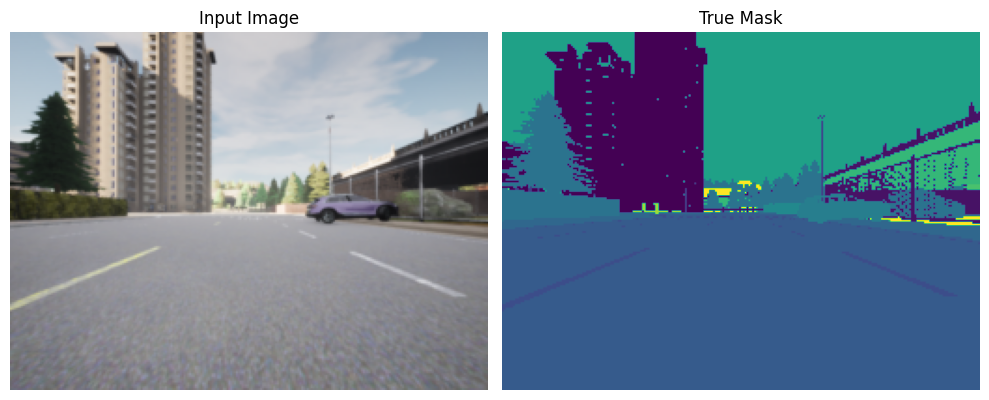

In [177]:
# Show first image of first batch and its corresponding mask from the dataset

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for X, y in train_dataloader:
    img = X[0]
    mask = y[0]
    ax[0].imshow(img.permute(1, 2, 0))
    ax[0].set_title("Input Image")
    ax[0].axis('off')
    ax[1].imshow(mask)
    ax[1].set_title("True Mask")
    ax[1].axis('off')
    break

plt.tight_layout()
plt.show()

<a name='3-7'></a>
### 3.7 - Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability.

We recommend using the cross entropy loss and the Adam optimizer.

In [178]:
criterion = nn.CrossEntropyLoss()

In [179]:
optimizer = torch.optim.Adam(unet.parameters(), lr=LR, betas=(B1, B2))

<a name='4'></a>
## 4 - Train the Model

Implement the `train` loop below to train the model.

In [180]:
%%time
losses = []
unet.train()
for epoch in range(EPOCHS):
    epoch_losses = []
    for i, batch in enumerate(train_dataloader):
        X, y = batch
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        pred = unet(X)

        loss = criterion(pred, y)

        loss.backward()

        optimizer.step()

        epoch_losses.append(loss.item())
#         losses.append(loss.item())
        print(f"EPOCH {epoch+1}/{EPOCHS}\t Batch {i}\t Loss: {loss.item():.5f}")
    losses.append(np.mean(epoch_losses))

EPOCH 1/15	 Batch 0	 Loss: 3.13477
EPOCH 1/15	 Batch 1	 Loss: 2.93488
EPOCH 1/15	 Batch 2	 Loss: 2.73917
EPOCH 1/15	 Batch 3	 Loss: 2.62464
EPOCH 1/15	 Batch 4	 Loss: 2.52042
EPOCH 1/15	 Batch 5	 Loss: 2.49842
EPOCH 1/15	 Batch 6	 Loss: 2.37493
EPOCH 1/15	 Batch 7	 Loss: 2.32208
EPOCH 1/15	 Batch 8	 Loss: 2.30580
EPOCH 1/15	 Batch 9	 Loss: 2.25442
EPOCH 1/15	 Batch 10	 Loss: 2.23253
EPOCH 1/15	 Batch 11	 Loss: 2.16931
EPOCH 1/15	 Batch 12	 Loss: 2.13105
EPOCH 1/15	 Batch 13	 Loss: 2.10629
EPOCH 1/15	 Batch 14	 Loss: 2.09833
EPOCH 1/15	 Batch 15	 Loss: 2.04171
EPOCH 1/15	 Batch 16	 Loss: 2.00763
EPOCH 1/15	 Batch 17	 Loss: 1.99941
EPOCH 1/15	 Batch 18	 Loss: 2.01508
EPOCH 1/15	 Batch 19	 Loss: 1.92839
EPOCH 1/15	 Batch 20	 Loss: 1.91075
EPOCH 1/15	 Batch 21	 Loss: 1.89428
EPOCH 1/15	 Batch 22	 Loss: 1.89206
EPOCH 1/15	 Batch 23	 Loss: 1.86684
EPOCH 1/15	 Batch 24	 Loss: 1.84197
EPOCH 1/15	 Batch 25	 Loss: 1.82781
EPOCH 1/15	 Batch 26	 Loss: 1.81558
EPOCH 1/15	 Batch 27	 Loss: 1.77244
EP

<a name='4-1'></a>
### 4.1 - Create Predicted Masks

Now, define a function that uses `torch.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

_(The Predicted class of each pixel is the argmax of different probs assigned to that pixel)_

In [181]:
def create_mask(pred_mask):
    # pred_mask has shape (N, C, H, W)
    pred_mask = torch.argmax(pred_mask, dim=1)
    return pred_mask

<a name='4-2'></a>
### 4.2 - Plot Loss Function

Plot the loss function value of your model in different iterations.

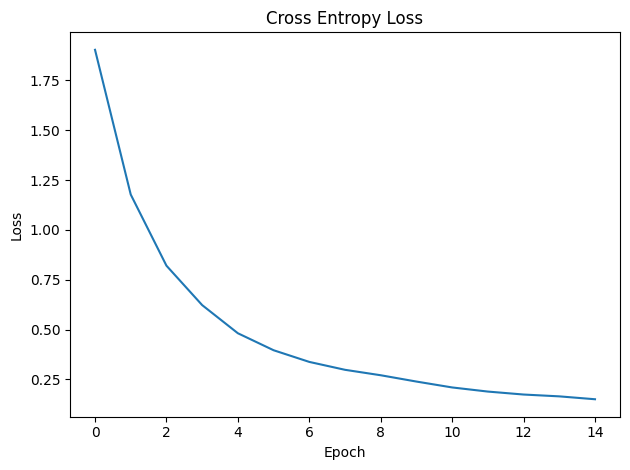

In [182]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross Entropy Loss')
plt.tight_layout()
plt.show()

<a name='4-3'></a>
### 4.3 - mIoU

calculate mIoU for test dataset images and report average mIoU for all the images. (Remember that we have 23 classes in our dataset)

You can read about _mIoU_ metric and how it works [here](https://www.jeremyjordan.me/evaluating-image-segmentation-models/). Also, there are some other good resources on _Medium_, _Wikipedia_ and etc. on this subject. Just search for **What is mIoU in semantic segmentation**.

**Important Note**: You _can_ use some helper functions from _scikit-learn_ library to calculate mIoU, but you can not use functions (from any library) that calculate mIoU or IoU directly. You need to implement the calculation of mIoU by yourself.

In [183]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_miou(y_true, y_pred, num_classes):
    iou = []
    for i in range(num_classes):
        intersection = np.sum((y_true == i) & (y_pred == i))
        union = np.sum((y_true == i) | (y_pred == i))
        if union == 0:
            continue
        iou.append(intersection / union)
    miou = np.mean(iou)
    return miou

In [184]:
num_classes = 23
mious = []
unet.eval()
for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        pred = unet(X)
        pred = create_mask(pred)
        for y_true, y_pred in zip(y, pred):
            miou = calculate_miou(y_true.cpu().numpy(), y_pred.cpu().numpy(), num_classes)
            mious.append(miou)

print(f"average miou for test dataset: {sum(mious) / len(mious):.5f}")


average miou for test dataset: 0.43886


<a name='4-3'></a>
### 4.5 - Show Predictions

Now, let's see your predictions (masks) vs ground truth masks to understand how well your model did.

In [185]:
def show_predictions(dataloader, device, num=1):
    """
    Displays the first image of each of the num batches
    """
    fig, axs = plt.subplots(num, 3, figsize=(15, 5*num))
    unet.eval()
    for i, batch in enumerate(dataloader):
        if i == num:
            break
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        pred = unet(X)
        pred = create_mask(pred)
        for j in range(X.shape[0]):
            axs[i, 0].imshow(X[j].cpu().permute(1, 2, 0))
            axs[i, 0].set_title("Input Image")
            axs[i, 0].axis('off')
            axs[i, 1].imshow(y[j].cpu())
            axs[i, 1].set_title("True Mask")
            axs[i, 1].axis('off')
            axs[i, 2].imshow(pred[j].cpu())
            axs[i, 2].set_title("Predicted Mask")
            axs[i, 2].axis('off')
            break
    plt.tight_layout()
    plt.show()

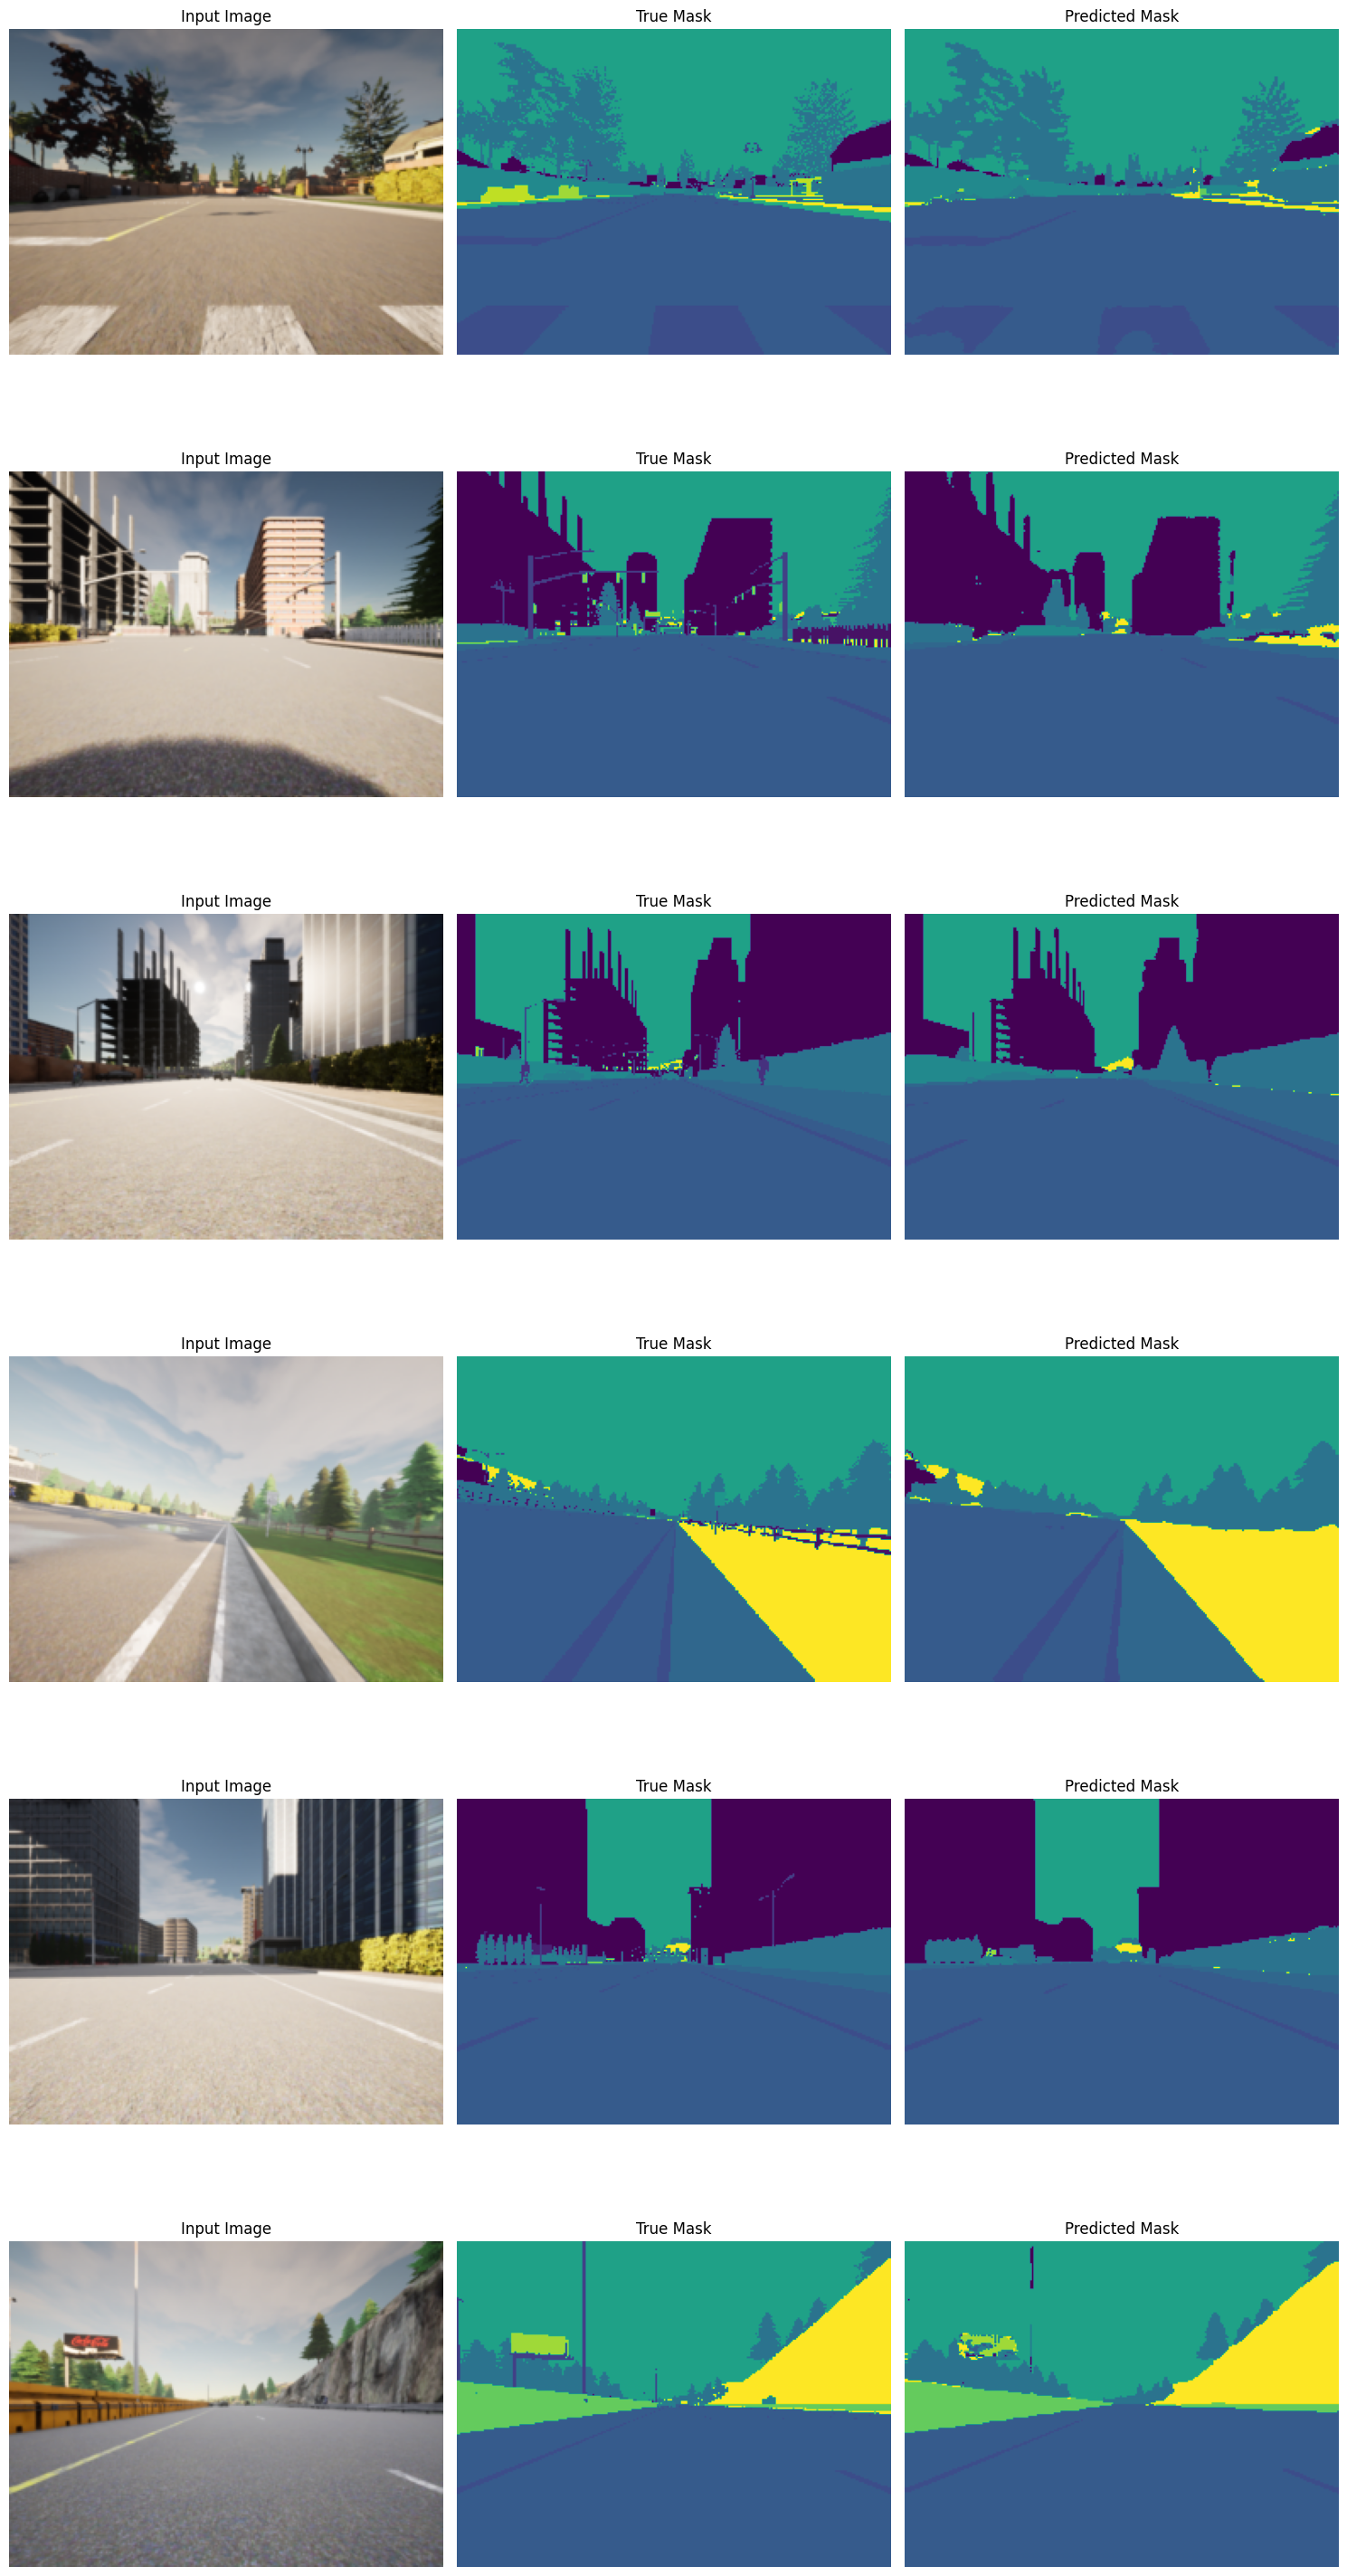

In [186]:
show_predictions(test_dataloader, device, 6)

## 5. Making the architecture better?!

Here, we want to try to make the UNet's model architecture, better. We try an approach named __Attention UNet__. This architecture tries to focus on the important parts of the image, and ignore the rest. Using this idea, we try to make the features (in `upsampling` steps) better, to finally reach a better __Decoder__ and thus, better predictions.

## 5.1 - Attention UNet

Here, is an overview of general architecture of Attention UNet:

<img src="./Images/1.png" style="width:100%;height:auto;">

As you can see, the architecture is similar to the UNet, but with the addition of Attention Gates. These gates are used to focus on the important parts of the image, and ignore the rest. But, what are these attention gates, precisely?!

<img src="./Images/2.png" style="width:100%;height:auto;">

As you can see, the attention gate is a simple architecture, which uses the features from the encoder, and the features from the decoder, adds them and also uses residual connections to output $\hat{x_l}$. Please note that $W_x \in \mathbb{R}^{F_l \times F_{int}}$, $W_g \in \mathbb{R}^{F_g \times F_{int}}$ and $\Psi \in \mathbb{R}^{F_{int} \times 1}$ are linear transformations which are being computed using channel-wise $1 \times 1 \times 1$ convolutions for the input tensors. In other contexts, this is called _vector concatenation-based attention_, where the concatenated features $x^l$ and $g$ are linearly mapped into a $\mathbb{R}^{F_{int}}$ dimensional _intermediate_ space.

Let's design the `AttentionBlock` class, which will be used in the `AttentionUNet` model:

In [187]:
""" Because we are dealing with images, D=1 so we can use 2D convolutions. """

class AttentionBlock(nn.Module):
    def __init__(self, F_l, F_int, F_g):
        super(AttentionBlock, self).__init__()
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1, stride=2)
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1, stride=1)
        self.psi = nn.Conv2d(F_int, 1, kernel_size=1, stride=1)
        self.relu = nn.ReLU()

    def forward(self, x, g):
        x1 = self.W_x(x)
        g1 = self.W_g(g)
        psi = self.relu(x1 + g1)
        psi = self.psi(psi)
        psi = torch.sigmoid(psi)
        
        psi = nn.functional.interpolate(psi, size=x.size()[2:], mode='bilinear', align_corners=True)

        return x * psi

You can define new `conv_block` and `upsample_block` to meet the requirements of the `AttentionUNet` model. If your previous `conv_block` and `upsample_block` functions are compatible, you can just use them!

In [188]:
class new_conv_block(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_prob=0):
        super(new_conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_ch)
        )
        self.dropout_prob = dropout_prob

    def forward(self, x):
        x = self.conv(x)
        if self.dropout_prob > 0:
            x = nn.functional.dropout2d(x, p=self.dropout_prob)
        return x

In [189]:
class new_upsample_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(new_upsample_block, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = new_conv_block(in_ch=out_ch * 2, out_ch=out_ch)
        self.attention = AttentionBlock(F_l=out_ch, F_int=out_ch, F_g=in_ch)

    def forward(self, x, x_att):
        x_up = self.up(x)
        x_att = self.attention(x_att, x)
        x = torch.cat([x_up, x_att], dim=1)
        x = self.conv(x)
        return x

In [190]:
class UNet_With_Attention(nn.Module):
    def __init__(self, in_ch=3, out_channel=23):
        """
        UNet with Attention

        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            out_channel -- Number of channels of output tensor
        """
        super().__init__()

        self.pool = nn.MaxPool2d(2, 2)
        
        # Down-sampling
        self.conv_block1 = new_conv_block(in_ch, 32)
        self.conv_block2 = new_conv_block(32, 64)
        self.conv_block3 = new_conv_block(64, 128)
        self.conv_block4 = new_conv_block(128, 256, dropout_prob=0.3)

        # Bottleneck
        self.bottleneck = new_conv_block(256, 512, dropout_prob=0.3)

        # Up-sampling and final layer
        self.up_block1 = new_upsample_block(512, 256)
        self.up_block2 = new_upsample_block(256, 128)
        self.up_block3 = new_upsample_block(128, 64)
        self.up_block4 = new_upsample_block(64, 32)

        self.final_conv = nn.Conv2d(32, out_channel, kernel_size=1)

    def forward(self, x):
        """
        UNet with Attention forward

        Arguments:
            x -- Input data/batch

        Returns:
            out -- Tensor output (Segmented image)
        """
        c1 = self.conv_block1(x)
        p1 = self.pool(c1)
        c2 = self.conv_block2(p1)
        p2 = self.pool(c2)
        c3 = self.conv_block3(p2)
        p3 = self.pool(c3)
        c4 = self.conv_block4(p3)
        p4 = self.pool(c4)

        bottleneck = self.bottleneck(p4)

        up1 = self.up_block1(bottleneck, c4)
        up2 = self.up_block2(up1, c3)
        up3 = self.up_block3(up2, c2)
        up4 = self.up_block4(up3, c1)

        out = self.final_conv(up4)

        return out

In [191]:
unet = UNet_With_Attention().to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR, betas=(B1, B2))
criterion = nn.CrossEntropyLoss()

Now, let's implement the training loop for our `Unet with Attention` model. (If you implemented a `train` function for previous part, you can simply reuse it here! If not, you can simply re-implement the loop)

In [192]:
%%time
losses = []
unet.train()
for epoch in range(EPOCHS):
    epoch_losses = []
    for i, batch in enumerate(train_dataloader):
        X, y = batch
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        pred = unet(X)

        loss = criterion(pred, y)

        loss.backward()

        optimizer.step()

        epoch_losses.append(loss.item())
        print(f"EPOCH {epoch+1}/{EPOCHS},\t Batch {i},\t Loss: {loss.item()}")
    losses.append(np.mean(epoch_losses))

EPOCH 1/15,	 Batch 0,	 Loss: 3.3114230632781982
EPOCH 1/15,	 Batch 1,	 Loss: 2.9456634521484375
EPOCH 1/15,	 Batch 2,	 Loss: 2.7406911849975586
EPOCH 1/15,	 Batch 3,	 Loss: 2.591343879699707
EPOCH 1/15,	 Batch 4,	 Loss: 2.377319097518921
EPOCH 1/15,	 Batch 5,	 Loss: 2.332331418991089
EPOCH 1/15,	 Batch 6,	 Loss: 2.213670015335083
EPOCH 1/15,	 Batch 7,	 Loss: 2.1035139560699463
EPOCH 1/15,	 Batch 8,	 Loss: 2.007169008255005
EPOCH 1/15,	 Batch 9,	 Loss: 1.9635952711105347
EPOCH 1/15,	 Batch 10,	 Loss: 1.8479558229446411
EPOCH 1/15,	 Batch 11,	 Loss: 1.7816914319992065
EPOCH 1/15,	 Batch 12,	 Loss: 1.7258793115615845
EPOCH 1/15,	 Batch 13,	 Loss: 1.6371091604232788
EPOCH 1/15,	 Batch 14,	 Loss: 1.6441478729248047
EPOCH 1/15,	 Batch 15,	 Loss: 1.5634655952453613
EPOCH 1/15,	 Batch 16,	 Loss: 1.5545321702957153
EPOCH 1/15,	 Batch 17,	 Loss: 1.513741374015808
EPOCH 1/15,	 Batch 18,	 Loss: 1.4864535331726074
EPOCH 1/15,	 Batch 19,	 Loss: 1.4132381677627563
EPOCH 1/15,	 Batch 20,	 Loss: 1.3902

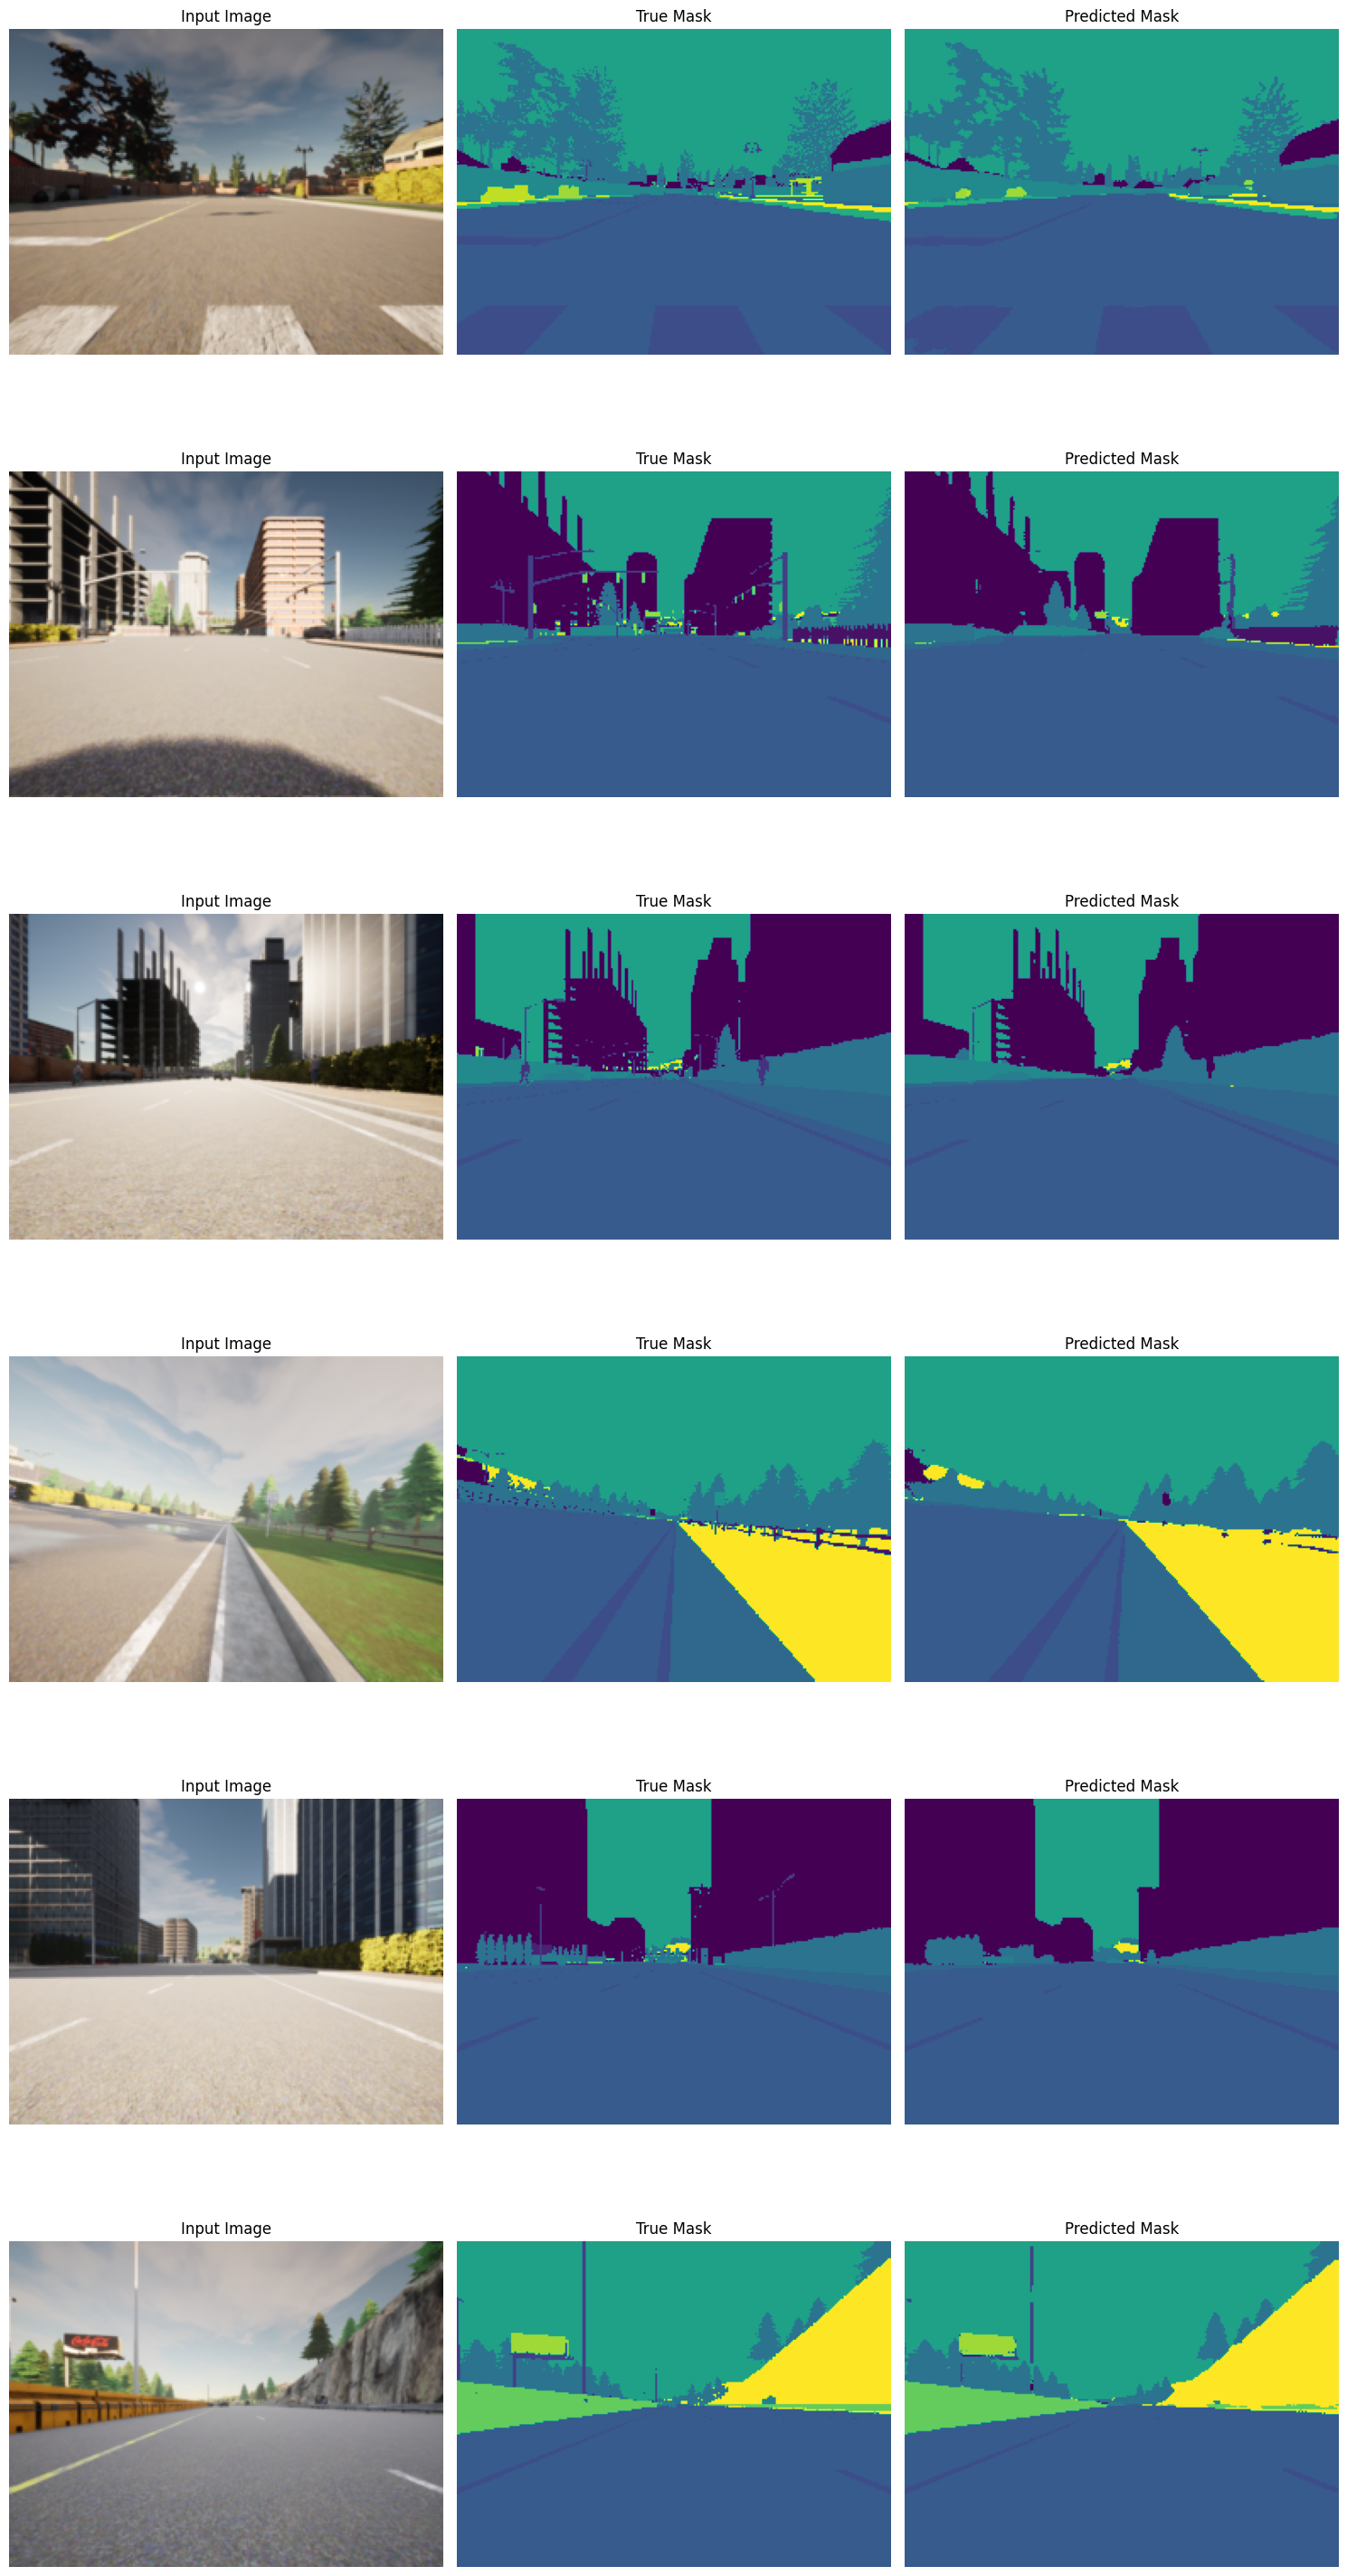

In [193]:
show_predictions(test_dataloader, device, 6)

Now, let's plot the `losses` vs `epochs` for the `AttentionUNet` model.

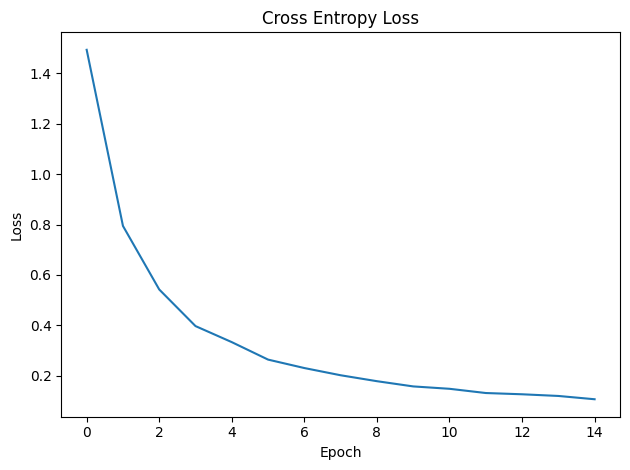

In [194]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross Entropy Loss')
plt.tight_layout()
plt.show()

<a name='5-2'></a>
### 5.2 - mIoU

calculate mIoU for test dataset images with new model using the defined function above and report average mIoU for all the images.

In [195]:
num_classes = 23
mious = []
unet.eval()
for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        pred = unet(X)
        pred = create_mask(pred)
        for y_true, y_pred in zip(y, pred):
            miou = calculate_miou(y_true.cpu().numpy(), y_pred.cpu().numpy(), num_classes)
            mious.append(miou)

print(f"average miou for test dataset: {sum(mious) / len(mious):.5f}")

average miou for test dataset: 0.50002


### 5.3 - Conclusion
Compare the results between `Unet` and `AttentionUNet` models. Do your comparison in terms of `mIoU` and `loss` values, and also the `training time`. Which one is better in each of these metrics? Explain your answer based on the outputs and plots and loss values and mIoU values.

**Answer**:

<font color='cyan'>

During upsampling in the expanding path, spatial information recreated is imprecise. To counteract this problem, the U-Net uses skip connections that combine spatial information from the downsampling path with the upsampling path. However, this brings across many redundant low-level feature extractions, as feature representation is poor in the initial layers.

</font>

- Metric **mIoU** for Attention U-Net is **higher**.
- The *training loss* for Attention U-Net is **lower**.
- While the Attention U-Net has more parameters, it is not significantly more and the inference time is **only marginally longer** (`1min 52s` vs `2min 5s`).

<font color='yellow'>
In conclusion, attention gates are a simple way to improve the U-Net consistently in a large variety of datasets without a significant overhead in terms of computational cost.
</font>

By hyperparameter tuning, we found that these values are the best:

```python
learning_rate = 0.0005
batch_size = 16
beta_1 = 0.9
beta_2 = 0.999
```

We used $15$ Epochs, Adam optimizer, `BatchNorm2d` after `Conv2d` layers, and `dropout_prob=0.3` for last two down-sampling blocks. Here are some results:

| Learning rate | Batch Size | mIoU | attention mIoU |
| --- | --- | --- | --- |
| 0.0001 | 16 | 0.33852 | - |
| 0.0003 | 16 | 0.43533 (0.36921) | - |
| 0.0005 | 16 | 0.43626 (0.38517) \[0.43886\] | \[0.50002\] |
| 0.0007 | 16 | (0.40272) \[0.42949\] | 0.48368 \[0.48519\] |

- () denotes `dropout_prob=0.5`
- \[\] denotes `dropout_prob=0.3`
- **mIoU**s without parentheses denotes `dropout_prob=0`

> We found that models without Batch Normalization act very poorly:

| Learning rate | Batch Size | mIoU (dropout_prob=0.3) | attention mIoU |
| --- | --- | --- | --- |
| 0.001 | 32 | 0.22264 | 0.25034 |
| 0.0001 | 16 | 0.25953 | 0.27811 |
| 0.0001 | 32 | 0.20858 (without dropout 0.21167) | 0.10999 |